# Installation des bibliothèques nécessaires

In [1]:
%%capture
%pip install -U transformers 
%pip install -U datasets 
%pip install -U accelerate 
%pip install -U peft 
%pip install -U trl 
%pip install -U bitsandbytes 
%pip install -U wandb

In [2]:
%pip install -U peft==0.11.1
%pip install -U "trl<0.9.0"

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 251.6/251.6 kB 7.7 MB/s eta 0:00:00
  Attempting uninstall: peft
    Found existing installation: peft 0.14.0
    Uninstalling peft-0.14.0:
      Successfully uninstalled peft-0.14.0
Note: you may need to restart the kernel to use updated packages.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 245.2/245.2 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.5/112.5 kB 8.8 MB/s eta 0:00:00
  Attempting uninstall: trl
    Found existing installation: trl 0.13.0
    Uninstalling trl-0.13.0:
      Successfully uninstalled trl-0.13.0
Note: you may need to restart the kernel to use updated packages.


# Importation des modules

In [3]:
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    BitsAndBytesConfig,
    HfArgumentParser,
    TrainingArguments,
    pipeline,
    logging,
)
from peft import (
    LoraConfig,
    PeftModel,
    prepare_model_for_kbit_training,
    get_peft_model,
)
import os, torch, wandb
from datasets import load_dataset
from trl import SFTTrainer, setup_chat_format

# Authentification et configuration des tokens

In [4]:
from huggingface_hub import login
from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()

hf_token = user_secrets.get_secret("HUGGINGFACE_TOKEN")

login(token = hf_token)

# Initialisation de WandB

In [5]:
wb_token = user_secrets.get_secret("wandb")

wandb.login(key=wb_token)
run = wandb.init(
    project='Fine-tune Llama 3 8B on Medical Dataset', 
    job_type="training", 
    anonymous="allow"
)

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: oussamanaya8 (oussamanaya8-hassan-ii-university-of-casablanca). Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Tracking run with wandb version 0.19.1
wandb: Run data is saved locally in /kaggle/working/wandb/run-20250106_173859-9tvgxgab
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run honest-armadillo-9
wandb: ⭐️ View project at https://wandb.ai/oussamanaya8-hassan-ii-university-of-casablanca/Fine-tune%20Llama%203%208B%20on%20Medical%20Dataset
wandb: 🚀 View run at https://wandb.ai/oussamanaya8-hassan-ii-university-of-casablanca/Fine-tune%2

# Définition des modèles et des configurations

In [6]:
base_model = "/kaggle/input/llama-3/transformers/8b-chat-hf/1"
dataset_name = "ruslanmv/ai-medical-chatbot"
new_model = "llama-3-8b-chat-doctor"

<li><b>Configuration torch pour le type de données et l'attention</b></li>

In [7]:
# Set torch dtype and attention implementation
if torch.cuda.get_device_capability()[0] >= 8:
    !pip install -qqq flash-attn
    torch_dtype = torch.bfloat16
    attn_implementation = "flash_attention_2"
else:
    torch_dtype = torch.float16
    attn_implementation = "eager"

<li>Configuration QLoRA</li>

In [8]:
# QLoRA config
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch_dtype,
    bnb_4bit_use_double_quant=True,
)

# Load model
model = AutoModelForCausalLM.from_pretrained(
    base_model,
    quantization_config=bnb_config,
    device_map="auto",
    attn_implementation=attn_implementation
)

# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained(base_model, trust_remote_code=True)

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

<li>Configuration LoRA</li>

In [9]:
# LoRA config
peft_config = LoraConfig(
    r=16,
    lora_alpha=32,
    lora_dropout=0.05,
    bias="none",
    task_type="CAUSAL_LM",
    target_modules=['up_proj', 'down_proj', 'gate_proj', 'k_proj', 'q_proj', 'v_proj', 'o_proj']
)
model = get_peft_model(model, peft_config)

# Importation et préparation du dataset

In [10]:
#Importing the dataset
dataset = load_dataset(dataset_name, split="all")
dataset = dataset.shuffle(seed=65).select(range(1000)) # Only use 1000 samples for quick demo

def format_chat_template(row):
    row_json = [{"role": "user", "content": row["Patient"]},
               {"role": "assistant", "content": row["Doctor"]}]
    row["text"] = tokenizer.apply_chat_template(row_json, tokenize=False)
    return row

dataset = dataset.map(
    format_chat_template,
    num_proc=4,
)

README.md:   0%|          | 0.00/863 [00:00<?, ?B/s]

dialogues.parquet:   0%|          | 0.00/142M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/256916 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/multiprocess/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Map (num_proc=4):   0%|          | 0/1000 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/multiprocess/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


In [11]:
dataset

Dataset({
    features: ['Description', 'Patient', 'Doctor', 'text'],
    num_rows: 1000
})

In [12]:
dataset['text'][3]

'<|begin_of_text|><|start_header_id|>user<|end_header_id|>\n\nFell on sidewalk face first about 8 hrs ago. Swollen, cut lip bruised and cut knee, and hurt pride initially. Now have muscle and shoulder pain, stiff jaw(think this is from the really swollen lip),pain in wrist, and headache. I assume this is all normal but are there specific things I should look for or will I just be in pain for a while given the hard fall?<|eot_id|><|start_header_id|>assistant<|end_header_id|>\n\nHello and welcome to HCM,The injuries caused on various body parts have to be managed.The cut and swollen lip has to be managed by sterile dressing.The body pains, pain on injured site and jaw pain should be managed by pain killer and muscle relaxant.I suggest you to consult your primary healthcare provider for clinical assessment.In case there is evidence of infection in any of the injured sites, a course of antibiotics may have to be started to control the infection.Thanks and take careDr Shailja P Wahal<|eot_i

In [13]:
dataset = dataset.train_test_split(test_size=0.1)

<h1>Complaining and training the model</h1>

In [14]:
#Hyperparamter
training_arguments = TrainingArguments(
    output_dir=new_model,
    per_device_train_batch_size=1,
    per_device_eval_batch_size=1,
    gradient_accumulation_steps=2,
    optim="paged_adamw_32bit",
    num_train_epochs=1,
    evaluation_strategy="steps",
    eval_steps=0.2,
    logging_steps=1,
    warmup_steps=10,
    logging_strategy="steps",
    learning_rate=2e-4,
    fp16=False,
    bf16=False,
    group_by_length=True,
    report_to="wandb"
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [15]:
# Setting sft parameters
trainer = SFTTrainer(
    model=model,
    train_dataset=dataset["train"],
    eval_dataset=dataset["test"],
    peft_config=peft_config,
    max_seq_length= 512,
    dataset_text_field="text",
    tokenizer=tokenizer,
    args=training_arguments,
    packing= False,
)

Map:   0%|          | 0/900 [00:00<?, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:323: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `SFTTrainer.__init__`. Use `processing_class` instead.
  super().__init__(


# Entraînement du modèle

In [16]:
tokenizer.pad_token = tokenizer.eos_token

In [17]:
trainer.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


Step,Training Loss,Validation Loss
90,2.736100,2.474172
180,2.338100,2.428293
270,2.322400,2.391291
360,2.604100,2.359087
450,1.884000,2.342914


Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:195: UserWarning: Could not find a config file in /kaggle/input/llama-3/

TrainOutput(global_step=450, training_loss=2.4748770451545714, metrics={'train_runtime': 1205.4947, 'train_samples_per_second': 0.747, 'train_steps_per_second': 0.373, 'total_flos': 9524041396396032.0, 'train_loss': 2.4748770451545714, 'epoch': 1.0})

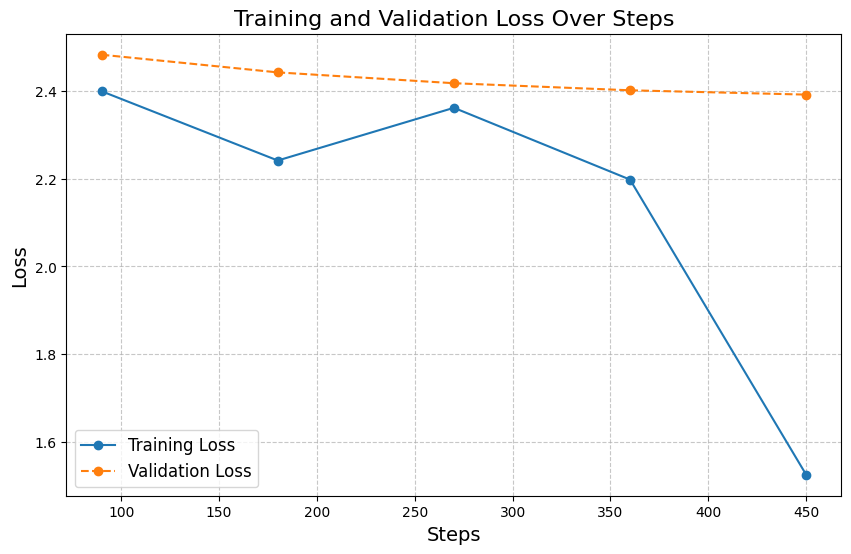

In [18]:
import matplotlib.pyplot as plt

# Données des étapes et des pertes
steps = [90, 180, 270, 360, 450]
training_loss = [2.400100, 2.241900, 2.362300, 2.198300, 1.524300]
validation_loss = [2.483516, 2.443169, 2.418442, 2.402273, 2.392415]

# Tracé des courbes
plt.figure(figsize=(10, 6))
plt.plot(steps, training_loss, label="Training Loss", marker='o', linestyle='-')
plt.plot(steps, validation_loss, label="Validation Loss", marker='o', linestyle='--')

# Ajout de titres et de légendes
plt.title("Training and Validation Loss Over Steps", fontsize=16)
plt.xlabel("Steps", fontsize=14)
plt.ylabel("Loss", fontsize=14)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)

# Affichage du graphe
plt.show()

<h1>Model evaluation</h1>

In [19]:
wandb.finish()
model.config.use_cache = True

wandb:                                                                                
wandb: 
wandb: Run history:
wandb:               eval/loss █▆▄▂▁
wandb:            eval/runtime ▄▁█▆▇
wandb: eval/samples_per_second ▅█▁▃▁
wandb:   eval/steps_per_second ▅█▁▃▁
wandb:             train/epoch ▁▁▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▄▄▄▄▄▄▄▅▅▆▆▆▇▇▇▇██
wandb:       train/global_step ▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▆▆▆▆▆▇▇▇▇▇█████
wandb:         train/grad_norm ▃▃█▄▅▅▅▂▄▄▄▃▅▄▁▃▄▆▄▂▂▃▃▄▅▅▅▇▁▃▅▄▆▆▁▂▂▄▃█
wandb:     train/learning_rate ▄███▇▇▇▇▇▇▆▆▆▆▆▅▅▅▅▅▅▅▄▄▄▃▃▃▃▃▃▃▃▂▂▂▂▂▁▁
wandb:              train/loss ▇▆▃▃▅▄▅▅▁▄▅▃▅▅▆▂▄▁▄▄▃▄▃▆▄▅█▅▂▅▄▄▃▇▄▅▃▅▄▅
wandb: 
wandb: Run summary:
wandb:                eval/loss 2.34291
wandb:             eval/runtime 48.0908
wandb:  eval/samples_per_second 2.079
wandb:    eval/steps_per_second 2.079
wandb:               total_flos 9524041396396032.0
wandb:              train/epoch 1
wandb:        train/global_step 450
wandb:          train/grad_norm 2.76906
wandb:      train/learning_rate 

<h1>Test</h1>

In [20]:
messages = [
    {
        "role": "user",
        "content": "Hello doctor, I have bad acne. How do I get rid of it?"
    }
]

In [21]:
prompt = tokenizer.apply_chat_template(messages, tokenize=False, 
                                       add_generation_prompt=True)

inputs = tokenizer(prompt, return_tensors='pt', padding=True, 
                   truncation=True).to("cuda")

outputs = model.generate(**inputs, max_length=150, 
                         num_return_sequences=1)

text = tokenizer.decode(outputs[0], skip_special_tokens=True)

print(text.split("assistant")[1])

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.




Hi. For more information consult a dermatologist online -->


<h1>Saving the model file</h1>

In [22]:
trainer.model.save_pretrained(new_model)
trainer.model.push_to_hub(new_model, use_temp_dir=False)

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:195: UserWarning: Could not find a config file in /kaggle/input/llama-3/transformers/8b-chat-hf/1 - will assume that the vocabulary was not modified.
  warnings.warn(


README.md:   0%|          | 0.00/5.17k [00:00<?, ?B/s]

adapter_model.safetensors:   0%|          | 0.00/168M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/OussamaNaya/llama-3-8b-chat-doctor/commit/5b297d56c9d8cd0c465a6ed63876bdab4b911091', commit_message='Upload model', commit_description='', oid='5b297d56c9d8cd0c465a6ed63876bdab4b911091', pr_url=None, repo_url=RepoUrl('https://huggingface.co/OussamaNaya/llama-3-8b-chat-doctor', endpoint='https://huggingface.co', repo_type='model', repo_id='OussamaNaya/llama-3-8b-chat-doctor'), pr_revision=None, pr_num=None)

Link to the model : <a href="https://huggingface.co/OussamaNaya/llama-3-8b-chat-doctor">
llama-3-8b-chat-doctor</a>